# ***English Dataset***

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Importing Dataset

sentiments = 3
df = pd.read_csv('/content/Twitter_Data.csv')
df.columns = ['sentence', 'sentiment']
df = df.dropna()
df

In [ ]:
#preprocessing
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# to remove emoji from the text
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def preprocess(df):


    # Convert every tweet to lower case
    df['sentence'] = df['sentence'].apply(lambda x : ' '.join(x.lower() for x in x.split()))

    # Remove punctuations
    df['sentence'] = df['sentence'].str.replace('[^\w\s]','')

    # remove emoji's
    df['sentence'] = df['sentence'].apply(lambda x: remove_emoji(x))

    # stop words
    stop = set(stopwords.words('english'))
    df['sentence'] = df['sentence'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop))

    # stemming
    ps = PorterStemmer()
    df['sentence'] = df['sentence'].apply(lambda x : ' '.join([ps.stem(word) for word in word_tokenize(x)]))

    return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# to find unique words in the whole corpus
def unique_words(df):
    sentences = df['sentence'].tolist()
    words = set(' '.join(sentence for sentence in sentences.split()))
    words = [i for i in words if not re.match("\S*\d\S*", i)] # to remove alpha numeric words
    print(f'no of unique words = {len(words)}')
    return words

In [ ]:
import math

def fuzzy_values(df, words):
    fuzzy_values = []
    total_words = sum([len(sentence.split()) for sentence in df['sentence']])
    total_sentences = len(df)
    prior_prob = [i/total_sentences for i in list(df['sentiment'].value_counts())[::-1]]

    for t in range(len(words)):
        ut_for_xt = []
        pxt = sum([sentence.count(words[t]) for sentence in df['sentence']]) / total_words
        for label in range(sentiments):
            qxt = sum([1 if df['sentiment'][i]==label-1 and words[i] in df['sentence'][i].split() else 0 for i in range(n)]) / total_sentences
            KtU = 0 if qxt == 0 else -pxt*(math.log(qxt, 10)) 

            pxt_label = qxt
            qxt_label = qxt / prior_prob[label]

            KLtU = -pxt_label * (0 if qxt_label == 0 else math.log(qxt_label, 10))

            KLt_xt = KtU - KLtU

            ut_for_xt.append(KLt_xt)
        fuzzy_values.append(ut_for_xt)

    return fuzzy_values

In [ ]:
from collections import defaultdict
df = preprocess(df)
n = len(df)
words = unique_words(df)
index = defaultdict(int)
for i in range(len(words)):
    index[words[i]] = i+1
fuzzy_values = fuzzy_values(df, words) # fuzzy values => weights for each word for every label

<ipython-input-86-a5a9c05017a2>:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df['sentence'] = df['sentence'].str.replace('[^\w\s]','')


no of unique words = 2495


In [ ]:
fuzzy_values

[[-0.00290933963136766, -0.003418956165843098, -0.010132251278937446],
 [-0.00328424864711096, -0.003793865181586398, -0.01044088424874108],
 [-0.001784612584137759, -0.002294229118613197, -0.009206352369526547],
 [0.00046484151032204213, -4.47750241533958e-05, -0.007354554550704747],
 [-0.00365915766285426, -0.004168774197329698, -0.010749517218544714],
 [-0.0025344306156243595, -0.0030440471500997974, -0.009823618309133813],
 [-0.00365915766285426, -0.004168774197329698, -0.010749517218544714],
 [-0.00365915766285426, -0.004168774197329698, -0.010749517218544714],
 [-0.001784612584137759, -0.002294229118613197, -0.009206352369526547],
 [-0.002159521599881059, -0.002669138134356497, -0.00951498533933018],
 [-0.00328424864711096, -0.003793865181586398, -0.01044088424874108],
 [-0.00290933963136766, -0.003418956165843098, -0.010132251278937446],
 [-0.00290933963136766, -0.003418956165843098, -0.010132251278937446],
 [-0.00328424864711096, -0.003793865181586398, -0.01044088424874108],
 [

In [ ]:
norm = [[1000,-1000] for i in range(sentiments)]
for i in range(len(fuzzy_values)):
    for j in range(sentiments):
        norm[j][0] = min(norm[j][0], fuzzy_values[i][j])
        norm[j][1] = max(norm[j][1], fuzzy_values[i][j])
print(norm)

# normalization
for i in range(len(fuzzy_values)):
    for j in range(sentiments):
        fuzzy_values[i][j] = (fuzzy_values[i][j] - norm[j][0]) / (norm[j][1] - norm[j][0])

fuzzy_values

[[-0.00365915766285426, 0.18604480430325565], [-0.004168774197329698, 0.18553518776878022], [-0.010749517218544714, 0.14541876550209373]]


[[0.0039525691699604714, 0.0039525691699604714, 0.00395256916996048],
 [0.0019762845849802357, 0.0019762845849802357, 0.0019762845849802344],
 [0.009881422924901184, 0.009881422924901184, 0.009881422924901183],
 [0.021739130434782605, 0.021739130434782605, 0.02173913043478261],
 [0.0, 0.0, 0.0],
 [0.00592885375494071, 0.00592885375494071, 0.0059288537549407145],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.009881422924901184, 0.009881422924901184, 0.009881422924901183],
 [0.007905138339920948, 0.007905138339920948, 0.007905138339920948],
 [0.0019762845849802357, 0.0019762845849802357, 0.0019762845849802344],
 [0.0039525691699604714, 0.0039525691699604714, 0.00395256916996048],
 [0.0039525691699604714, 0.0039525691699604714, 0.00395256916996048],
 [0.0019762845849802357, 0.0019762845849802357, 0.0019762845849802344],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0039525691699604714, 0.0039525691699604714, 0.00395256916996048],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.007905138339920948, 0.007905138

In [ ]:
maxsenlen = max([len(sen.split()) for sen in x_train])
features = []
for sen in x_train:
    sen_fuzzy = []
    for word in sen.split():
        sen_fuzzy.append(fuzzy_values[index[word]-1])
    for i in range(maxsenlen - min(maxsenlen, len(sen_fuzzy))):
        sen_fuzzy.append([0 for i in range(sentiments)])
    features.append(sen_fuzzy)
features = np.array(features)

In [ ]:
features.shape

(80, 43, 3)

In [ ]:
X_train = np.reshape(features, newshape=(-1, 129,))

In [ ]:
X_train.shape

(80, 129)

In [ ]:
# convert sentiments to catogorical vectors

def categorical(y):
    ans = [[0, 0, 0] for i in range(len(y))]
    j =  0
    for i in y:
        ans[j][int(i)+1] = 1
        j += 1
    return np.array(ans)

Y_train = categorical(y_train)
Y_test = categorical(y_test)

In [ ]:
Y_test

array([[0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [ ]:
import tensorflow as tf

# Initializing the ANN
ann = tf.keras.models.Sequential()
# Add the input layer and first hidden layer
ann.add(tf.keras.layers.Dense(units=12, activation='relu', input_shape=(X_train.shape[1],)))
# Add the second hidden layer
ann.add(tf.keras.layers.Dense(units=8, activation='relu'))
# Add the output layer
ann.add(tf.keras.layers.Dense(units=3, activation='sigmoid'))

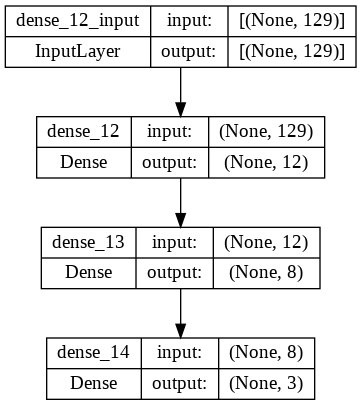

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(ann,
           to_file="model.png",
           show_shapes=True,
           show_layer_names=True,
          )

In [ ]:
ann.compile(optimizer = 'adam', loss = tf.keras.losses.binary_crossentropy, metrics = ['accuracy'])
ann.fit(X_train, Y_train, batch_size = 32, epochs = 100)

Epoch 1/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6840 - accuracy: 0.3375
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.3625
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6776 - accuracy: 0.3875
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6745 - accuracy: 0.3875
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6715 - accuracy: 0.3875
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 0.6683 - accuracy: 0.3875
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 0.6653 - accuracy: 0.4000
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6622 - accuracy: 0.4000
Epoch 9/100
3/3 [==============================] - 0s 5ms/step - loss: 0.6590 - accuracy: 0.4000
Epoch 10/100
3/3 [==============================] - 0s 5ms/step - loss: 0.6564 - accuracy: 0.4000
Epoch 11/100
3/3 [===========

In [ ]:
# prediction

X_test_features = []

for sen in x_test:
    test_sen_fuzzy = []
    for word in sen:
        if index[word] > 0:
            test_sen_fuzzy.append(fuzzy_values[index[word]-1])
    if len(test_sen_fuzzy) < maxsenlen:
        for i in range(maxsenlen-len(test_sen_fuzzy)):
            test_sen_fuzzy.append([0 for j in range(sentiments)])
    else:
        test_sen_fuzzy = test_sen_fuzzy[:maxsenlen]
    X_test_features.append(test_sen_fuzzy)

X_test_features = np.array(X_test_features)
X_test = np.reshape(X_test_features, newshape=(-1,129,))

In [ ]:
predict = ann.predict(X_test, batch_size=50, verbose=1)
y_pred = np.array(predict)
y_pred

99/99 [==============================] - 0s 1ms/step


array([[0.2713021, 0.5042876, 0.2769424],
       [0.2713021, 0.5042876, 0.2769424],
       [0.2713021, 0.5042876, 0.2769424],
       ...,
       [0.2713021, 0.5042876, 0.2769424],
       [0.2713021, 0.5042876, 0.2769424],
       [0.2713021, 0.5042876, 0.2769424]], dtype=float32)

In [ ]:
# predicted labels

pred_labels = [np.argmax(output) for output in y_pred]
pred_labels

labels = [np.argmax(output) for output in Y_test]
labels

In [ ]:
from sklearn.metrics import accuracy_score 
accuracy_score(labels, pred_labels)

# ***Hindi Dataset***

In [ ]:
import pandas as pd
import numpy as np

# positive sentences
f = open('/content/pos_hindi.txt', 'r')
data = []
for line in f.read().split('\n'):
    data.append([line.replace('$', ''), 1])

# negative sentences
f = open('/content/neg_hindi.txt', 'r')
for line in f.read().split('\n'):
    if line != ' ' and line != '':
        data.append([line.replace('$', ''), -1])

# dataframe
df = pd.DataFrame(data, columns=['sentence', 'label'])
df

,sentence,label
0,मिकी वाइरस पूरी तरह से मनीष पॉल की फिल्म है और...,1
1,मनीष ने अपने किरकार को बखूबी निभाया है,1
2,"उन्होंने शाहिद के डर, खौफ, संघर्ष, जिद और जीत ...",1
3,वे हर भाव के दृश्यों में नैचुरल लगते हैं,1
4,फिल्म की कास्टिंग जबरदस्त है,1
...,...,...
1102,इंटरवल के बाद फिल्म उलझ जाती है।,-1
1103,अगर डायरेक्टर बार - बार हीरो राम द्वारा घर की ...,-1
1104,मैं गलियों से निकलता हूं फिर भी फंस जाता हूं।,-1
1105,क्लाइमेक्स भी बेवजह खींचा गया महसूस होता है।,-1


In [ ]:
# preprocessing
stopwords = open('/content/hindi_stopwords.txt').read().split('\n')

def preprocess(df):

    # remove stopwords
    df['sentence'] = df['sentence'].apply(lambda sen : ' '.join(word for word in sen.split() if word not in stopwords))

    # remove punctuations
    words_list = ['(', ')', "'", '"', '.', ',', '-', '/',"\\"]
    df['sentence'] = df['sentence'].apply(lambda sen : ''.join(letter for letter in sen if letter not in words_list))

    # remove numbers or alphanumeric words

    df['sentence'] = df['sentence'].apply(lambda sen : ' '.join(word for word in sen.split() if not re.match("\S*\d\S*", word)))

    return df
   

In [ ]:
df = preprocess(df)
df

,sentence,label
0,मिकी वाइरस पूरी मनीष पॉल फिल्म फिल्म इमेज हिसा...,1
1,मनीष किरकार बखूबी निभाया,1
2,उन्होंने शाहिद डर खौफ संघर्ष जिद जीत बखूबी व्यक्त,1
3,हर भाव दृश्यों नैचुरल लगते,1
4,फिल्म कास्टिंग जबरदस्त,1
...,...,...
1102,इंटरवल फिल्म उलझ जाती है।,-1
1103,अगर डायरेक्टर बार बार हीरो राम छत चढ़ संस्कृत ...,-1
1104,मैं गलियों निकलता हूं फंस जाता हूं।,-1
1105,क्लाइमेक्स बेवजह खींचा महसूस है।,-1


In [ ]:
# to find unique words in the whole corpus
import re
def unique_words(df):
    words = set()
    df['sentence'].str.split().apply(words.update)
    words = sorted(words)
    words = [i for i in words if len(i) > 1]
    print(f'no of unique words = {len(words)}')
    return words

In [ ]:
words = unique_words(df)

no of unique words = 3400


In [ ]:
import math

def fuzzyvalues(df, words, sentiments):
    n = len(df)
    fuzzy_values = []
    total_words = sum([len(sentence.split()) for sentence in df['sentence']])
    total_sentences = len(df)
    prior_prob = [i/total_sentences for i in list(df['label'].value_counts())[::-1]]

    for t in range(len(words)):
        ut_for_xt = []
        pxt = sum([sentence.count(words[t]) for sentence in df['sentence']]) / total_words
        for label in range(sentiments):
            qxt = sum([1 if df['label'][i]==2*label-1 and words[i] in df['sentence'][i].split() else 0 for i in range(n)]) / total_sentences
            KtU = 0 if qxt == 0 else -pxt*(math.log(qxt, 10)) 

            pxt_label = qxt
            qxt_label = qxt / prior_prob[label]

            KLtU = -pxt_label * (0 if qxt_label == 0 else math.log(qxt_label, 10))

            KLt_xt = KtU - KLtU

            ut_for_xt.append(KLt_xt)
        fuzzy_values.append(ut_for_xt)

    return fuzzy_values

In [ ]:
fuzzy_values = fuzzyvalues(df, words, 2)

In [ ]:
fuzzy_values

[[-0.0021249195067166073, -0.002186711878018715],
 [-0.0014830328180758647, -0.0015448251893779724],
 [-0.0014830328180758647, -0.0015448251893779724],
 [-0.0018039761623962359, -0.0018657685336983436],
 [-0.0018039761623962359, -0.0018657685336983436],
 [-0.0021249195067166073, -0.002186711878018715],
 [-0.0021249195067166073, -0.002186711878018715],
 [-0.0018039761623962359, -0.0018657685336983436],
 [0.0026892306580889635, 0.0026274382867868557],
 [-0.0021249195067166073, -0.002186711878018715],
 [-0.0021249195067166073, -0.002186711878018715],
 [-0.0021249195067166073, -0.002186711878018715],
 [-0.0011620894737554932, -0.001223881845057601],
 [0.00012168390352599234, 5.9891532223884606e-05],
 [-0.0021249195067166073, -0.002186711878018715],
 [-0.0021249195067166073, -0.002186711878018715],
 [-0.0021249195067166073, -0.002186711878018715],
 [-0.0021249195067166073, -0.002186711878018715],
 [-0.0018039761623962359, -0.0018657685336983436],
 [-0.0021249195067166073, -0.002186711878018

In [ ]:
norm = [[1000,-1000], [1000,-1000]]
for i in range(len(fuzzy_values)):
    for j in range(2):
        norm[j][0] = min(norm[j][0], fuzzy_values[i][j])
        norm[j][1] = max(norm[j][1], fuzzy_values[i][j])
print(norm)
print(fuzzy_values[0])
# normalization
for i in range(len(fuzzy_values)):
    for j in range(2):
        fuzzy_values[i][j] = (fuzzy_values[i][j] - norm[j][0]) / (norm[j][1] - norm[j][0])

fuzzy_values

[[-0.0021249195067166073, 0.13716449192832458], [-0.002186711878018715, 0.13710269955702248]]
[-0.0021249195067166073, -0.002186711878018715]


[[0.0, 0.0],
 [0.004608294930875574, 0.004608294930875574],
 [0.004608294930875574, 0.004608294930875574],
 [0.002304147465437788, 0.002304147465437788],
 [0.002304147465437788, 0.002304147465437788],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.002304147465437788, 0.002304147465437788],
 [0.034562211981566816, 0.034562211981566816],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.006912442396313363, 0.006912442396313363],
 [0.016129032258064512, 0.016129032258064512],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.002304147465437788, 0.002304147465437788],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.02764976958525345, 0.02764976958525345],
 [0.002304147465437788, 0.002304147465437788],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.004608294930875574, 0.004608294930875574],
 [0.046082949308755755, 0.046082949308755755],
 [0.0, 0.0],
 [0.002304147465437788, 0.002304147465437788],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0368663594470046, 0.0368663594470046],
 [0.0, 0.0],
 [0.05990783410138249, 0.05990783410138249],
 [0.01612